<a href="https://colab.research.google.com/github/iimustafa/Arabic_Handwritten_Digits/blob/main/EfficientNetB5_Bone_Marrow_Classification_96_97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bone-marrow-cell-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1855740%2F3082954%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240505%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240505T113553Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9f2711f98999d2dd46808078ffe23335cc67784111d37d23709eb64b0c75010546fd2a5aa0ee8836a3ca407d636dd9f1c2610c439d45b1104aeb3fe79b05148483fc23976f3c333aa7e4c5be877f10537e0e4a23d822eadcadbc6439c02479853b22ca2890887905305140196d547f3686ca34c52a2d78cd82cc3d7666e67046ca74edab06d9f5c6ada820cd8f47ae18924af8b1b35c7c8f0eb125a4405379d7b66b4409d608a74942c9bb7bc670e03f4ee67ea1016e476d596c9fcf4eaa618f53a9ca5339edb81d5a3bd608c295a1278d7ed21a9952bda8911cc7ff907987b679a51a1bc3e9969634327a15b1673902227fb8270d1bbcb61be25f0a2c5f467b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 6932749114 bytes downloaded
Downloaded and uncompressed: bone-marrow-cell-classification
Data source import complete.


In [3]:
import os
import cv2
import time
import shutil
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
sns.set_style('darkgrid')
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

print ('modules loaded')

modules loaded


In [18]:
def define_paths(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        fold_path = os.path.join(data_dir, fold)
        files = os.listdir(fold_path)
        for file in files:
            fpath = os.path.join(fold_path, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(data_dir):
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)

    strat = df['labels']
    train_df, test_df = train_test_split(df,  train_size= 0.9, shuffle= True, random_state= 123, stratify= strat)

    return train_df, test_df

In [19]:
def create_gens(train_df, test_df):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    batch_size = 40
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, test_gen

In [20]:
def show_images(gen):
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes)
    images, labels = next(gen)        # get a batch size samples from the generator
    plt.figure(figsize= (20, 20))
    length = len(labels)              # length of batch size
    sample = min(length, 25)          # check if sample less than 25 images
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [22]:
### Define a class for custom callback
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold, factor, batches, initial_epoch, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to runn per epoch
        self.initial_epoch = initial_epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training
        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights

    def on_train_batch_end(self, batch, logs= None):
        acc = logs.get('accuracy') * 100 # get batch accuracy
        loss = logs.get('loss')
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '') # prints over on the same line to show running batch count

    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()



    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                else:
                    self.count = self.count + 1 # increment the patience counter
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)


        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)
                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training
                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch ' + str(self.ask_epoch)
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)
                        except:
                            print('Invalid')

In [23]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)     # get number of epoch with the lowest validation loss
    val_lowest = val_loss[index_loss]    # get the loss value of epoch with the lowest validation loss
    index_acc = np.argmax(val_acc)       # get number of epoch with the highest validation accuracy
    acc_highest = val_acc[index_acc]     # get the loss value of epoch with the highest validation accuracy

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]	       # create x-axis by epochs count
    loss_label = f'best epoch= {str(index_loss + 1)}'  # label of lowest val_loss
    acc_label = f'best epoch= {str(index_acc + 1)}'    # label of highest val_accuracy
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Testing loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Testing Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

Found 1174 validated image filenames belonging to 7 classes.
Found 132 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 159 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 17 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


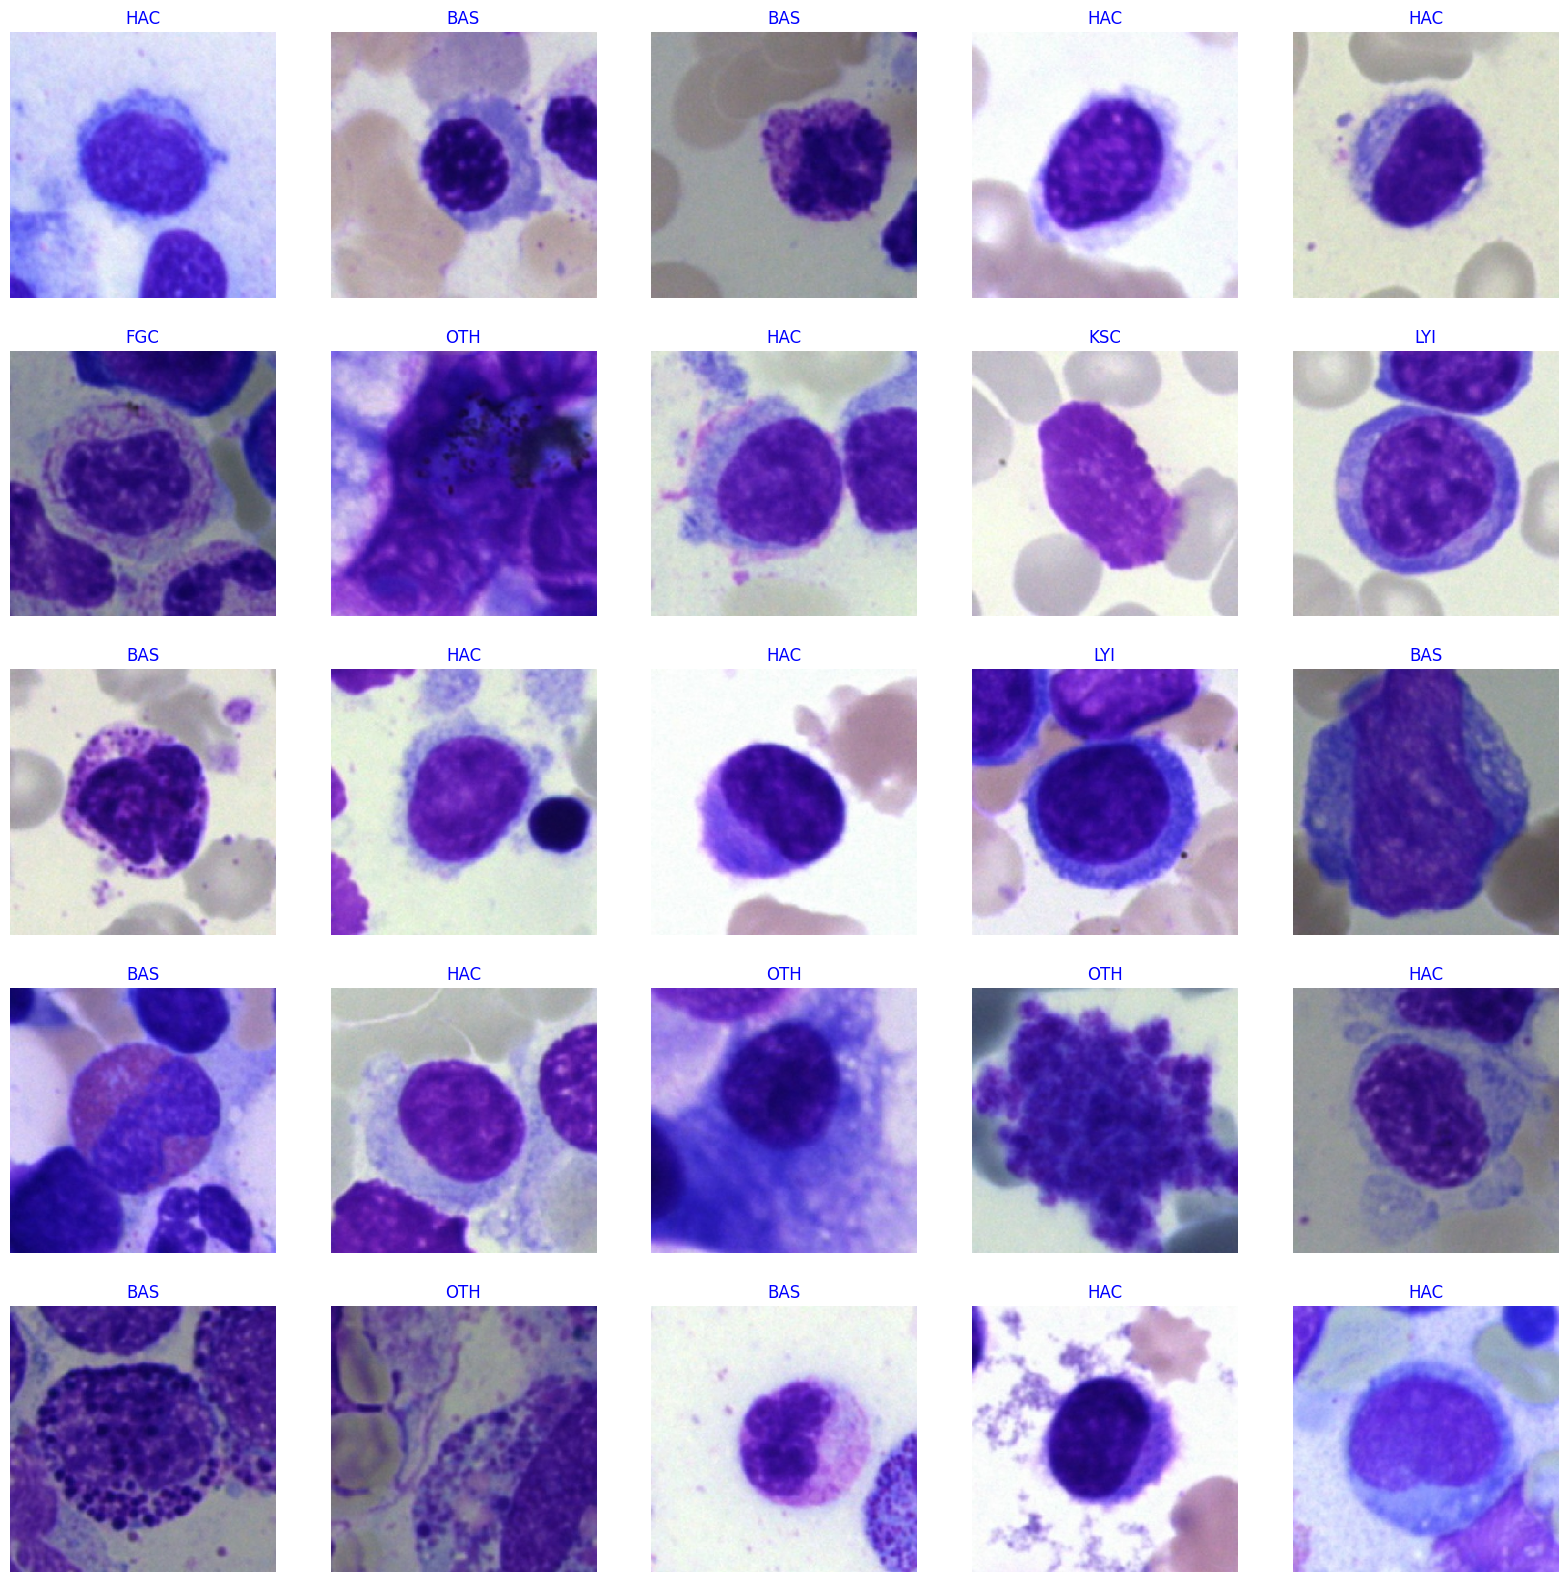

In [24]:
# Get Dataframes
data_dir = '../input/bone-marrow-cell-classification/bone_marrow_cell_dataset'
train_df, test_df = create_df(data_dir)

# Get Generators
train_gen, test_gen = create_gens(train_df, test_df)

show_images(train_gen)

**ResNet 50**

In [109]:
from keras.applications.resnet50 import ResNet50

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model
base_model_resnet50 = tf.keras.applications.resnet50.ResNet50(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

resnet50_model = Sequential([
    base_model_resnet50,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dropout(rate= 0.45),
    Dense(512, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45),
    Dense(128, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),


    Dropout(rate= 0.45),
    Dense(class_count, activation= 'softmax')
])

resnet50_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

resnet50_model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_872 (B  (None, 2048)              8192      
 atchNormalization)                                              
                                                                 
 dropout_44 (Dropout)        (None, 2048)              0         
                                                                 
 dense_71 (Dense)            (None, 128)               262272    
                                                                 
 dropout_45 (Dropout)        (None, 128)               0         
                                                                 
 dense_72 (Dense)            (None, 7)                

In [110]:
batch_size = 64
epochs = 50
patience = 1 		# number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9 	# if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.5 		# factor to reduce lr by
freeze = False 		# if true free weights of  the base model
ask_epoch = 5		# number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))

callbacks = [MyCallback(model= resnet50_model, base_model= base_model_resnet50, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            batches= batches, initial_epoch= 0, epochs= epochs, ask_epoch= ask_epoch )]

In [111]:
resnet50_history = resnet50_model.fit(x= train_gen, epochs= epochs, verbose= 1,
                    validation_data= test_gen, validation_steps= None, shuffle= False,
                    initial_epoch= 0)

Epoch 1/50
30/30 [==============================] - 37s 263ms/step - loss: 6.2468 - accuracy: 0.5162 - val_loss: 526.3909 - val_accuracy: 0.3106
Epoch 2/50
30/30 [==============================] - 5s 174ms/step - loss: 5.0906 - accuracy: 0.7445 - val_loss: 418.7157 - val_accuracy: 0.2500
Epoch 3/50
30/30 [==============================] - 5s 173ms/step - loss: 4.6560 - accuracy: 0.8279 - val_loss: 11.4253 - val_accuracy: 0.5303
Epoch 4/50
30/30 [==============================] - 5s 174ms/step - loss: 4.3773 - accuracy: 0.8603 - val_loss: 5.6409 - val_accuracy: 0.7500
Epoch 5/50
30/30 [==============================] - 5s 177ms/step - loss: 4.1704 - accuracy: 0.8782 - val_loss: 14.4506 - val_accuracy: 0.5303
Epoch 6/50
30/30 [==============================] - 5s 175ms/step - loss: 3.9260 - accuracy: 0.9106 - val_loss: 4.4918 - val_accuracy: 0.8106
Epoch 7/50
30/30 [==============================] - 5s 176ms/step - loss: 3.7439 - accuracy: 0.9387 - val_loss: 3.9528 - val_accuracy: 0.8561

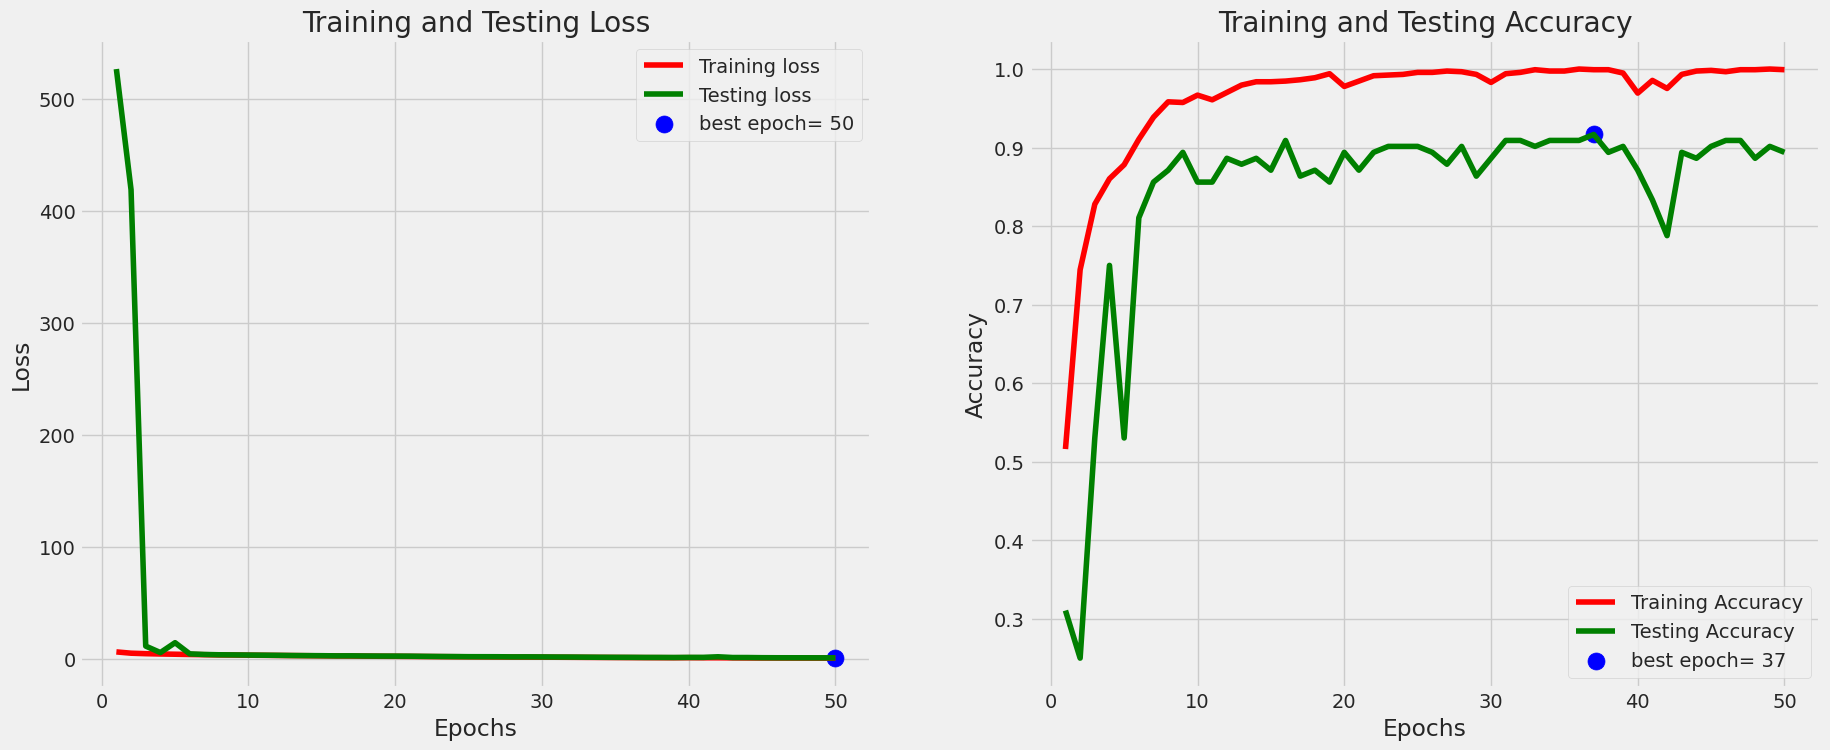

In [112]:
plot_training(resnet50_history)

In [114]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = resnet50_model.evaluate(train_gen, steps= test_steps, verbose= 1)
test_score = resnet50_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

 29/149 [====>.........................] - ETA: 11s - loss: 0.6261 - accuracy: 1.0000

129/149 [========================>.....] - ETA: 0s - loss: 0.9129 - accuracy: 0.8992

149/149 [==============================] - 1s 9ms/step - loss: 0.9325 - accuracy: 0.8939
Train Loss:  0.6261242628097534
Train Accuracy:  1.0
--------------------
Test Loss:  0.9325333833694458
Test Accuracy:  0.8939393758773804


In [125]:
from keras.applications.resnet50 import ResNet50

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model
base_model_resnet50_flat = tf.keras.applications.resnet50.ResNet50(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

resnet50_model_flat = Sequential([
    base_model_resnet50_flat,
    Flatten(),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dropout(rate= 0.45),
    Dense(512, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45),
    Dense(128, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),


    Dropout(rate= 0.45),
    Dense(class_count, activation= 'softmax')
])

resnet50_model_flat.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

resnet50_model_flat.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_875 (B  (None, 2048)              8192      
 atchNormalization)                                              
                                                                 
 dropout_51 (Dropout)        (None, 2048)              0         
                                                                 
 dense_79 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_52 (Dropout)        (None, 512)               0         
                                                     

In [126]:
batch_size = 64
epochs = 50
patience = 1 		# number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9 	# if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.5 		# factor to reduce lr by
freeze = False 		# if true free weights of  the base model
ask_epoch = 5		# number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))

callbacks = [MyCallback(model= resnet50_model_flat, base_model= resnet50_model_flat, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            batches= batches, initial_epoch= 0, epochs= epochs, ask_epoch= ask_epoch )]

In [127]:
resnet50_flat_history = resnet50_model_flat.fit(x= train_gen, epochs= epochs, verbose= 1,
                    validation_data= test_gen, validation_steps= None, shuffle= False,
                    initial_epoch= 0)

Epoch 1/50
30/30 [==============================] - 33s 215ms/step - loss: 24.6762 - accuracy: 0.3348 - val_loss: 38262.7578 - val_accuracy: 0.3106
Epoch 2/50
30/30 [==============================] - 5s 173ms/step - loss: 22.2761 - accuracy: 0.3543 - val_loss: 1033.1898 - val_accuracy: 0.3561
Epoch 3/50
30/30 [==============================] - 5s 174ms/step - loss: 21.2369 - accuracy: 0.3612 - val_loss: 20.1190 - val_accuracy: 0.4167
Epoch 4/50
30/30 [==============================] - 5s 176ms/step - loss: 20.3174 - accuracy: 0.3578 - val_loss: 70.6659 - val_accuracy: 0.4015
Epoch 5/50
30/30 [==============================] - 5s 175ms/step - loss: 19.4970 - accuracy: 0.3859 - val_loss: 22.5033 - val_accuracy: 0.4470
Epoch 6/50
30/30 [==============================] - 5s 173ms/step - loss: 18.6594 - accuracy: 0.3850 - val_loss: 17.9881 - val_accuracy: 0.4242
Epoch 7/50
30/30 [==============================] - 5s 174ms/step - loss: 18.0403 - accuracy: 0.4072 - val_loss: 18.5650 - val_acc

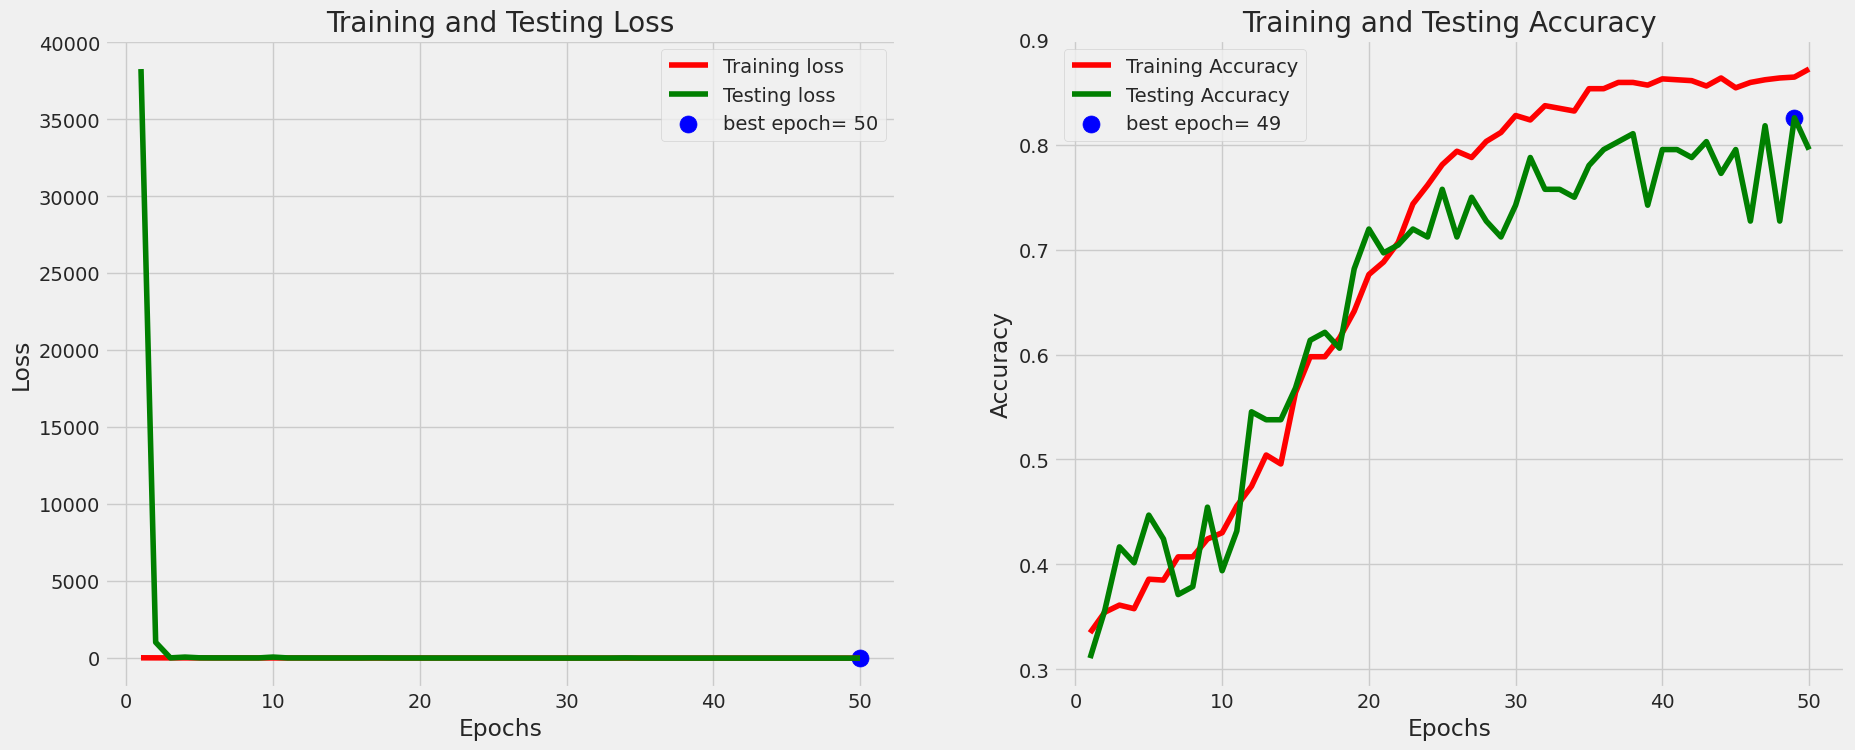

In [128]:
plot_training(resnet50_flat_history)

In [129]:
# Testing ResNet 50 using Flatten() layer:

ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = resnet50_model_flat.evaluate(train_gen, steps= test_steps, verbose= 1)
test_score = resnet50_model_flat.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

 29/149 [====>.........................] - ETA: 11s - loss: 3.2170 - accuracy: 0.8733

129/149 [========================>.....] - ETA: 0s - loss: 3.4565 - accuracy: 0.7984

149/149 [==============================] - 1s 8ms/step - loss: 3.4701 - accuracy: 0.7955
Train Loss:  3.2181713581085205
Train Accuracy:  0.8739352822303772
--------------------
Test Loss:  3.4701268672943115
Test Accuracy:  0.7954545617103577


**Inception V3**

In [63]:
from keras.applications.inception_v3 import InceptionV3
# from keras.applications.resnet50 import ResNet50
# from keras.applications.xception import Xception

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model
base_model_inception = tf.keras.applications.inception_v3.InceptionV3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

inception_model = Sequential([
    base_model_inception,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dropout(rate= 0.45, seed= 123),
    Dense(128, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

inception_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

inception_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 batch_normalization_855 (B  (None, 2048)              8192      
 atchNormalization)                                              
                                                                 
 dropout_13 (Dropout)        (None, 2048)              0         
                                                                 
 dense_25 (Dense)            (None, 128)               262272    
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 7)                 903       
                                                      

In [64]:
batch_size = 40
epochs = 20
patience = 1 		# number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9 	# if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.5 		# factor to reduce lr by
freeze = False 		# if true free weights of  the base model
ask_epoch = 5		# number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))

callbacks = [MyCallback(model= inception_model, base_model= base_model_inception, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            batches= batches, initial_epoch= 0, epochs= epochs, ask_epoch= ask_epoch )]

In [65]:
history = inception_model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= test_gen, validation_steps= None, shuffle= False,
                    initial_epoch= 0)

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /20     6.341   46.763  25.71034  31.061   0.00100  0.00100  accuracy     0.00    33.21  
 2 /20     5.008   74.702  12.20806  43.939   0.00100  0.00100  accuracy    59.74     4.78  
 3 /20     4.508   83.135   5.18534  62.121   0.00100  0.00100  accuracy    11.29     4.74  
 4 /20     4.348   87.819   4.81507  68.939   0.00100  0.00100  accuracy     5.64     4.70  
 5 /20     4.067   91.652   9.23232  67.424   0.00100  0.00050  val_loss    -91.74    4.68  
enter H to halt training or an integer for number of epochs to run then ask again
1
 training will continue until epoch 6
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 6 /20     3.973   92.164   4.12895  82.576   0.00050  0.00050  val_loss    14.25     4.74  
enter H to halt training or an integer for number of epochs to run then ask again
1
 training will continue until epoch 7
 Epoch     Los

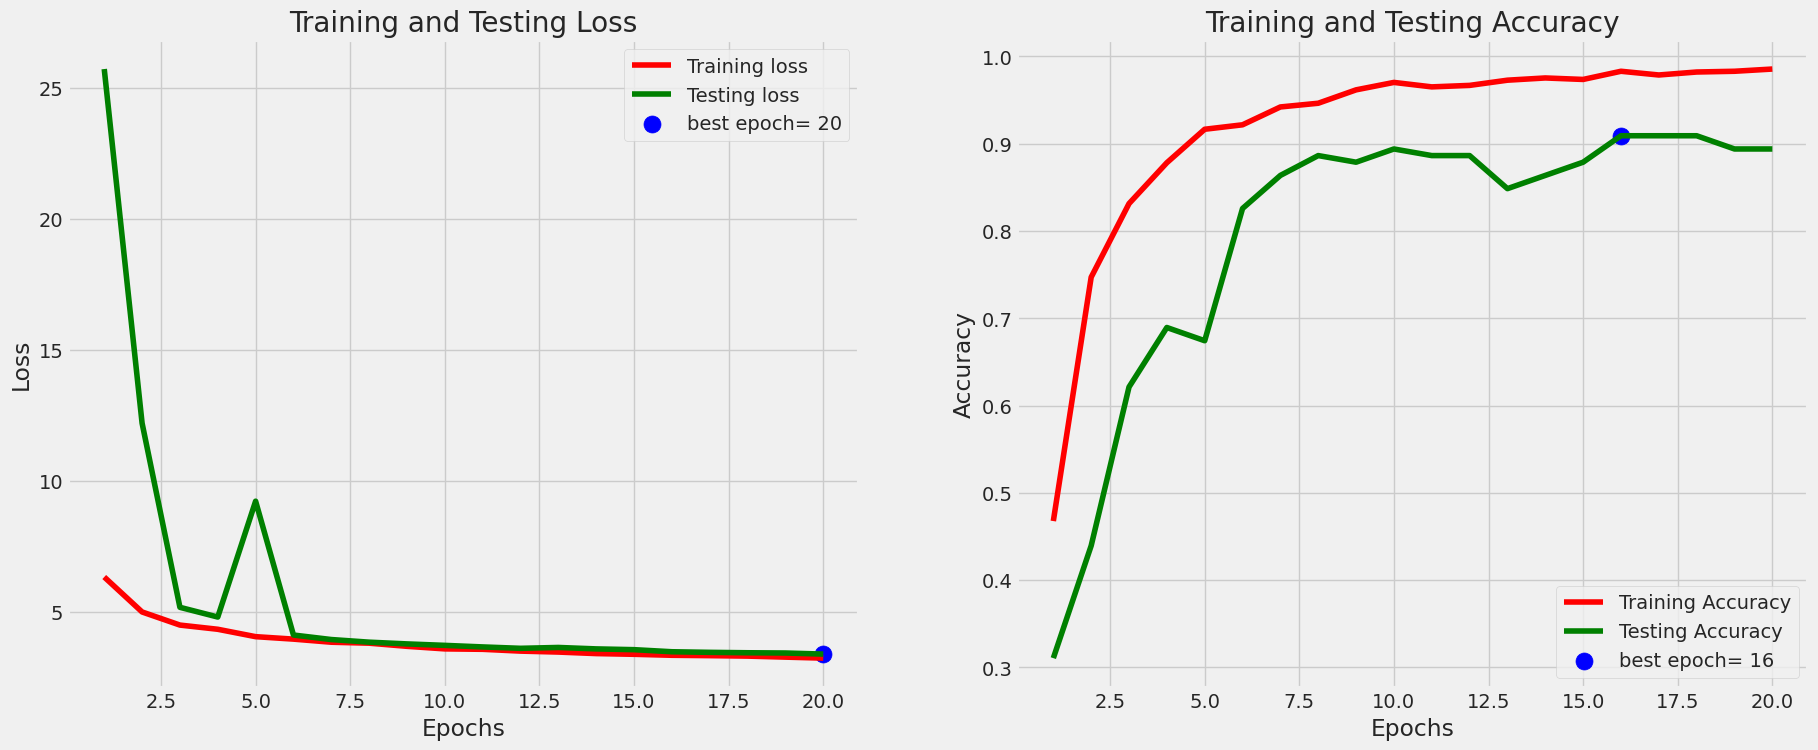

In [66]:
plot_training(history)

In [115]:
# Testing Inception:

ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = inception_model.evaluate(train_gen, steps= test_steps, verbose= 1)
test_score = inception_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

 29/149 [====>.........................] - ETA: 10s - loss: 3.1178 - accuracy: 0.9983

129/149 [========================>.....] - ETA: 0s - loss: 3.3927 - accuracy: 0.8992

149/149 [==============================] - 2s 12ms/step - loss: 3.4020 - accuracy: 0.8939
Train Loss:  3.1183152198791504
Train Accuracy:  0.9982964396476746
--------------------
Test Loss:  3.4020423889160156
Test Accuracy:  0.8939393758773804
